In [10]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt

fn = 'data/test/test_382cedb7-3579-4b3f-b533-1fab36d5a3f2_2025.01_18.nc'
ds = nc.Dataset(fn)

Load data set and libraries.

In [11]:
for dim in ds.dimensions.values():
    print(dim)

"<class 'netCDF4.Dimension'>" (unlimited): name = 'time', size = 730
"<class 'netCDF4.Dimension'>": name = 'lon', size = 280
"<class 'netCDF4.Dimension'>": name = 'lat', size = 144


In [12]:
for var in ds.variables.values():
    print(var)

<class 'netCDF4.Variable'>
float64 time(time)
    standard_name: time
    long_name: time
    units: days since 1978-12-31 0:0:0
    calendar: standard
    axis: T
unlimited dimensions: time
current shape = (730,)
filling off
<class 'netCDF4.Variable'>
float64 lon(lon)
    standard_name: longitude
    long_name: lon
    units: degrees_east
    axis: X
unlimited dimensions: 
current shape = (280,)
filling off
<class 'netCDF4.Variable'>
float64 lat(lat)
    standard_name: latitude
    long_name: lat
    units: degrees_north
    axis: Y
unlimited dimensions: 
current shape = (144,)
filling off
<class 'netCDF4.Variable'>
float32 AirTemperatureMean(time, lat, lon)
    units: degrees
    _FillValue: -999.0
    missing_value: -999.0
unlimited dimensions: time
current shape = (730, 144, 280)
filling off


These are the details of our dataset:
time: This is measured in days since 1978-12-31 0:0:0. We can view the value with ds['time'][t]
longitude: This is just the longitude of the grid point. We can view the value with ds['lon'][x]
latitude: This is just the latitude of the grid point. We can view the value with ds['lat'][y]

These values are the dimensions of the dataset, (time, lon, lat) -> feature value

We are testing with the average air temperature:

mean_temp = ds['AirTemperatureMean'][t][x][y]



In [13]:
x = 0
lat = []
lon = []
for y in range(len(ds['AirTemperatureMean'][x])):
    for v in range(len(ds['AirTemperatureMean'][x][y])):
        val = ds['AirTemperatureMean'][x][y][v]
        if val is not np.ma.masked:
            lat.append(ds['lat'][y])
            lon.append(ds['lon'][v])

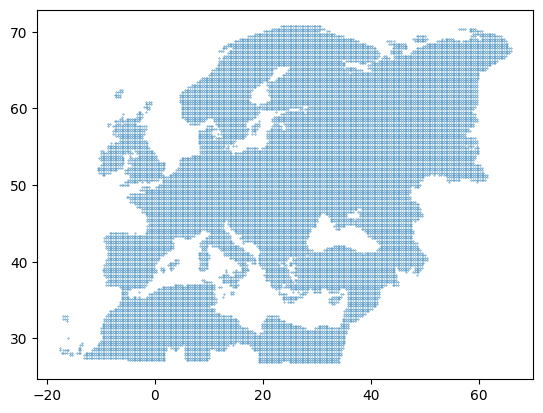

In [14]:
# kind of see a map of europe lol
plt.scatter(lon, lat, s=0.1)
plt.show()

With this we can think of how to map other data points to these grid points, do we use the closest grid point to map that data?
Or is the data average calculated in the square between points?

Lets calculate the closest gridpoint to the csv data we have.

Do this by loading the csv data and calculating a distance matrix between the points in the lat/lon arrays? Then take the min and see what happens, if multiple wosis datapoints map to a point we will take the average of them.

In [ ]:
import pandas as pd

fn_wosis = './data/wosis_latest/wosis_latest_orgc.csv'
wosis = pd.read_csv(fn_wosis)

wosis

So we map things by the X and Y: X = lon, Y = lat

In [15]:
# matrix lon, lat matrix of non masked values
jrc_XY = np.array([lon, lat]).T

In [ ]:
# calc distance from wosis pts to each jrc pt, might take a while
from scipy.spatial.distance import cdist
dist = cdist(wosis[['X', 'Y']], jrc_XY)
print(wosis[['X', 'Y']].shape)
print(jrc_XY.shape)
print(dist.shape)

count = {}
for d in dist:
    i = d.argmin()
    if i in count:
        count[i] += 1
    else:
        count[i] = 0

print(len(count))
for k, v in count.items():
    print(jrc_XY[k])
# print(jrc_XY[dist[0].argmin()])
# print(jrc_XY[dist[1].argmin()])
# print(jrc_XY[dist[2].argmin()])
# print(wosis[['X', 'Y']])

In [12]:
import requests

req = 'https://rest.isric.org/soilgrids/v2.0/properties/query?lon=5.041940&lat=46.659943&property=bdod&property=cec&property=cfvo&property=clay&property=nitrogen&property=ocd&property=ocs&property=phh2o&property=sand&property=silt&property=soc&property=wv0010&property=wv0033&property=wv1500&depth=0-5cm&depth=0-30cm&depth=5-15cm&depth=15-30cm&depth=30-60cm&depth=60-100cm&depth=100-200cm&value=Q0.5&value=Q0.05&value=Q0.95&value=mean&value=uncertainty'
small_req = 'https://rest.isric.org/soilgrids/v2.0/properties/query?lon=5.041940&lat=46.659943&property=nitrogen&depth=0-5cm&depth=0-30cm&depth=5-15cm&depth=15-30cm&depth=30-60cm&depth=60-100cm&depth=100-200cm&value=mean'
r = requests.get(small_req)

In [13]:
r.json()

{'type': 'Feature',
 'geometry': {'type': 'Point', 'coordinates': [5.04194, 46.659943]},
 'properties': {'layers': [{'name': 'nitrogen',
    'unit_measure': {'d_factor': 100,
     'mapped_units': 'cg/kg',
     'target_units': 'g/kg',
     'uncertainty_unit': ''},
    'depths': [{'range': {'top_depth': 0,
       'bottom_depth': 5,
       'unit_depth': 'cm'},
      'label': '0-5cm',
      'values': {'mean': 605}},
     {'range': {'top_depth': 5, 'bottom_depth': 15, 'unit_depth': 'cm'},
      'label': '5-15cm',
      'values': {'mean': 220}},
     {'range': {'top_depth': 15, 'bottom_depth': 30, 'unit_depth': 'cm'},
      'label': '15-30cm',
      'values': {'mean': 216}},
     {'range': {'top_depth': 30, 'bottom_depth': 60, 'unit_depth': 'cm'},
      'label': '30-60cm',
      'values': {'mean': 208}},
     {'range': {'top_depth': 60, 'bottom_depth': 100, 'unit_depth': 'cm'},
      'label': '60-100cm',
      'values': {'mean': 153}},
     {'range': {'top_depth': 100, 'bottom_depth': 200, '

Calculating the new longitudes going 25km east:

the km to change lon by 1 degree at lat x, km_1_degree = (pi/180) * (radius of earth) * cos(x in radians) <- km/degree
pi/180 converts the radians to degrees 

In [14]:
import math

r_earth = 6371
pi_180 = math.pi / 180

# test calculation with latitude
lat_rads = math.radians(46.659943)

denom = pi_180 * r_earth * math.cos(lat_rads)

def delta_lon(d_km, latitude):
    return d_km / (pi_180 * r_earth * math.cos(math.radians(latitude)))

In [ ]:
delta_lon(25, 46.659943)

In [16]:
small_req_moved = f'https://rest.isric.org/soilgrids/v2.0/properties/query?lon={5.041940+0.0045}&lat=46.659943&property=nitrogen&depth=0-5cm&depth=0-30cm&depth=5-15cm&depth=15-30cm&depth=30-60cm&depth=60-100cm&depth=100-200cm&value=mean'

r2 = requests.get(small_req_moved)

In [ ]:
r2.json()

Now to calculate the latitude change!
This one is much more simple in comparison, it doesn't rely on the lon!

In [18]:
def delta_lat(d_km):
    return d_km / (pi_180 * r_earth)

So we can see that it changes when we move by 25 km east, so we need to do a 250km x 250km search and average the results,
assuming the point is in the middle we go west by 125 km and south by 125 km

In [16]:
from itertools import product

def calc_grid_pts(latitude, longitude):
    # the jrc  is 25km x 25km resolution
    # soilgrid is 250m x 250m resolution
    # == meaning 25/0.25 = 100 => 100 x 100 (or 10000 soil grid pts to average per jrc pt... YIKES)

    # calc corner coord of grid
    start_lat = latitude - delta_lat(12.5)
    end_lat = latitude + delta_lat(12.5)
    start_lon = longitude - delta_lon(12.5, start_lat)

    # calc all lon deltas, lon delta relies on lat values
    lat_delta = delta_lat(0.25) # 250m delta, will stay constant
    lats = np.array([(start_lat + (x * lat_delta)) for x in range(100)])

    # delta for going 250m, it depends on the lats
    lon_deltas = np.array([delta_lon(0.25, x) for x in lats])

    lons = np.empty((len(lats), len(lon_deltas)))
    for lon_delta, i in zip(lon_deltas, range(len(lons))):
        lons[i] = np.array([(start_lon + (x * lon_delta)) for x in range(100)])

    coords = np.empty(shape=(0, 2))
    for lat, lon in zip(lats, lons):
        coords = np.concatenate((coords, np.array(list(product([lat], lon)))))
    return coords

def bulk_calc_grid_pts(grid):
    coords = []
    for lat, lon in grid:
        coords.append(calc_grid_pts(lat, lon))
    return np.array(coords)

def get_request_property_vals(data):
    layers = []
    for layer in data['properties']['layers']:
        l_values = []
        for depth in layer['depths']:
            v = depth['values']['mean']
            if v:
                l_values.append(depth['values']['mean'])
            else:
                break
        if v:
            layers.append(np.array(l_values))
            
    return np.array(layers)

def avg_250_grid(coords, request):
    # (lat, lon) starting pos
    # request, w/o the lat & lon
    grid_vals = []
    for lat, lon in coords:
        r = requests.get(request+f'&lon={lon}&lat={lat}')
        data = r.json()
        print(data)
        grid_vals.append(get_request_property_vals(data))

    return np.array(grid_vals)

In [ ]:
import timeit

timeit.timeit(lambda: calc_grid_pts(46.659943, 5.04194), number=40320) # it do be takin a while, but! it precalcs everything so its not so bad?

In [ ]:
full_coords = bulk_calc_grid_pts(jrc_XY)

In [ ]:
q = 'https://rest.isric.org/soilgrids/v2.0/properties/query?property=nitrogen&property=phh2o&depth=0-5cm&depth=0-30cm&depth=5-15cm&depth=15-30cm&depth=30-60cm&depth=60-100cm&depth=100-200cm&value=mean'
data = avg_250_grid(coords=full_coords[0], request=q)

variable_name: Soil pH in H2O
variable_units: pH*10
service_url: https://maps.isric.org/mapserv?map=/map/phh2o.map
service_id: phh2o
coverage_id: phh2o_0-5cm_mean
crs: urn:ogc:def:crs:EPSG::152160
bounding_box: (-1784000, 1356000, -1140000, 1863000)
grid_res: [250, 250]


/home/kwest/.local/lib/python3.10/site-packages/xarray/plot/utils.py:260: RuntimeWarning: overflow encountered in scalar absolute
  vlim = max(abs(vmin - center), abs(vmax - center))


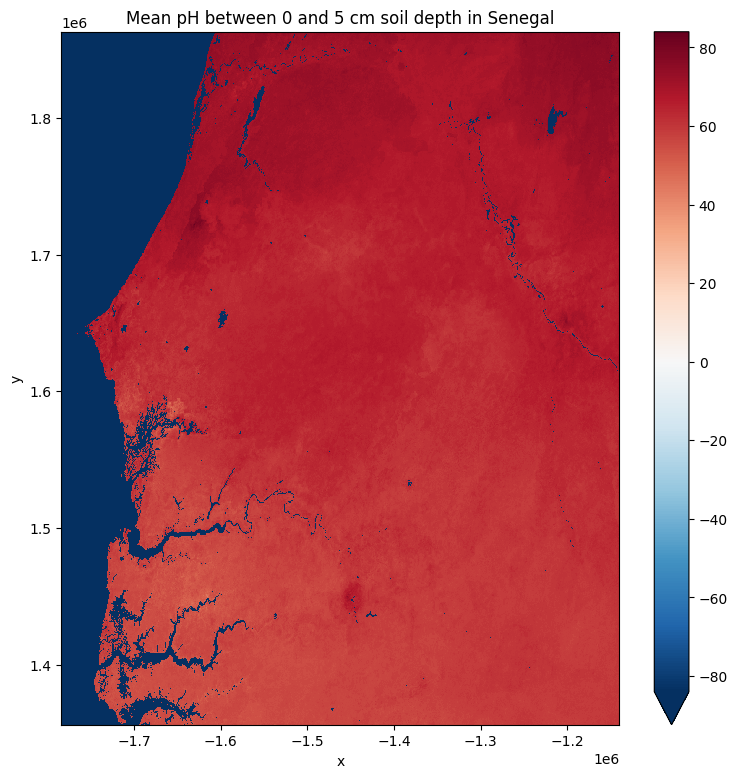

In [78]:
import matplotlib.pyplot as plt
from soilgrids import SoilGrids

# get data from SoilGrids
soil_grids = SoilGrids()
data = soil_grids.get_coverage_data(service_id='phh2o', coverage_id='phh2o_0-5cm_mean', 
                                       west=-1784000, south=1356000, east=-1140000, north=1863000,  
                                       crs='urn:ogc:def:crs:EPSG::152160',output='test.tif')

# show metadata
for key, value in soil_grids.metadata.items():
    print('{}: {}'.format(key,value))


# plot data
data.plot(figsize=(9,9))
plt.title('Mean pH between 0 and 5 cm soil depth in Senegal')
plt.show()

In [79]:
data

<xarray.DataArray (band: 1, y: 2028, x: 2576)> Size: 10MB
[5224128 values with dtype=int16]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 21kB -1.784e+06 -1.784e+06 ... -1.14e+06 -1.14e+06
  * y            (y) float64 16kB 1.863e+06 1.863e+06 ... 1.356e+06 1.356e+06
    spatial_ref  int64 8B 0
Attributes:
    TIFFTAG_XRESOLUTION:     72
    TIFFTAG_YRESOLUTION:     72
    TIFFTAG_RESOLUTIONUNIT:  2 (pixels/inch)
    _FillValue:              -32768
    scale_factor:            1.0
    add_offset:              0.0

In [27]:
soil_grids.get_coverage_info(service_id='phh2o', coverage_id='phh2o_0-5cm_mean')

Supported CRS: 
urn:ogc:def:crs:EPSG::152160
urn:ogc:def:crs:EPSG::4326
urn:ogc:def:crs:EPSG::3857
urn:ogc:def:crs:EPSG::54012
urn:ogc:def:crs:EPSG::152160

Coverage Bounding Box: 
EPSG:4326
(-179.998360809347, -55.9773009202418, 179.994461880094, 82.7192840534453)
EPSG:152160
(-19949750.0, -6147500.0, 19861750.0, 8361000.0)



variable_name: Soil pH in H2O
variable_units: pH*10
service_url: https://maps.isric.org/mapserv?map=/map/phh2o.map
service_id: phh2o
coverage_id: phh2o_0-5cm_mean
crs: urn:ogc:def:crs:EPSG::4326
bounding_box: (-17.84, 13.56, -11.4, 18.63)
grid_res: [0.0064399999999999995, 0.005069999999999997]


/home/kwest/.local/lib/python3.10/site-packages/xarray/plot/utils.py:260: RuntimeWarning: overflow encountered in scalar absolute
  vlim = max(abs(vmin - center), abs(vmax - center))


Text(0.5, 1.0, 'Mean pH between 0 and 5 cm soil depth in Senegal')

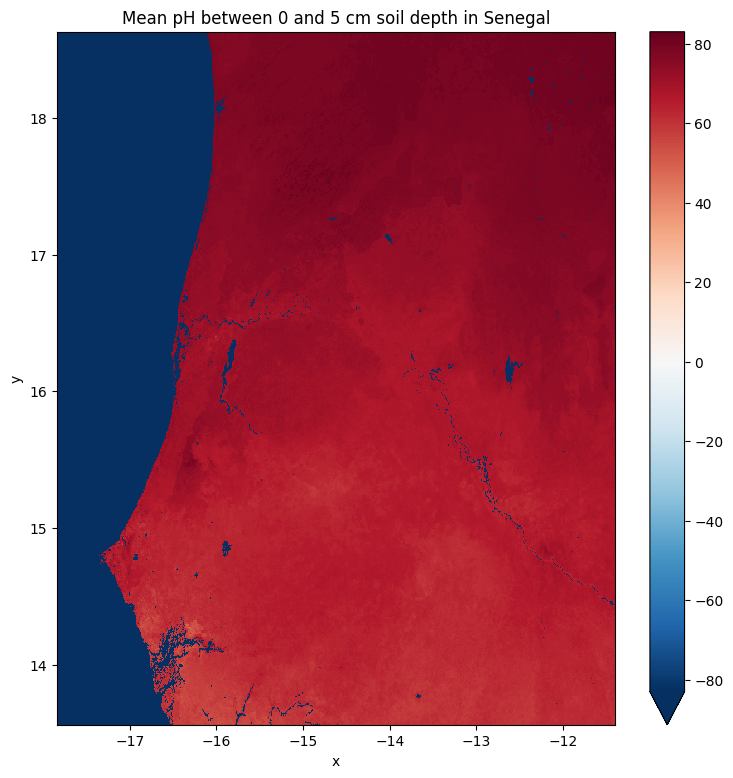

In [1]:
import matplotlib.pyplot as plt
from soilgrids import SoilGrids

# get data from SoilGrids
soil_grids = SoilGrids()
data = soil_grids.get_coverage_data(service_id='phh2o', coverage_id='phh2o_0-5cm_mean', 
                                       west=-17.84000, south=13.56000, east=-11.40000, north=18.63000,  
                                       crs='urn:ogc:def:crs:EPSG::4326',output='test.tif', height=1000, width=1000)

# show metadata
for key, value in soil_grids.metadata.items():
    print('{}: {}'.format(key,value))


# plot data
data.plot(figsize=(9,9))
plt.title('Mean pH between 0 and 5 cm soil depth in Senegal')

variable_name: Soil pH in H2O
variable_units: pH*10
service_url: https://maps.isric.org/mapserv?map=/map/phh2o.map
service_id: phh2o
coverage_id: phh2o_0-5cm_mean
crs: urn:ogc:def:crs:EPSG::4326
bounding_box: (3.215424, 50.134808, 8.126557, 53.81976)
grid_res: [0.004911132999999999, 0.003684952000000002]


/home/kwest/.local/lib/python3.10/site-packages/xarray/plot/utils.py:260: RuntimeWarning: overflow encountered in scalar absolute
  vlim = max(abs(vmin - center), abs(vmax - center))


Text(0.5, 1.0, 'Mean pH between 0 and 5 cm soil depth in The Netherlands')

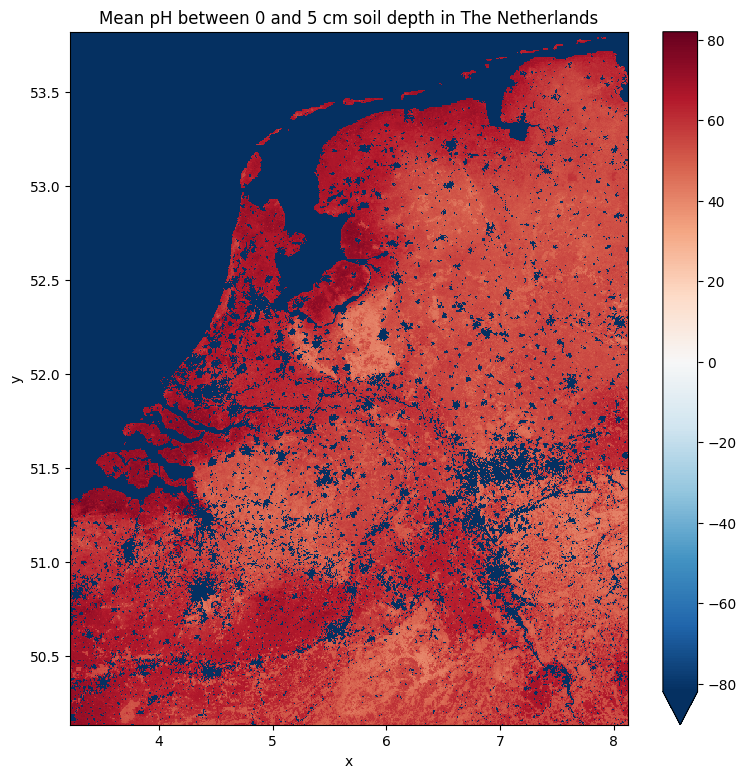

In [29]:
# 52.134808, 4.215424
# 53.819760, 8.126557

import matplotlib.pyplot as plt
from soilgrids import SoilGrids

# get data from SoilGrids
soil_grids = SoilGrids()
data = soil_grids.get_coverage_data(service_id='phh2o', coverage_id='phh2o_0-5cm_mean', 
                                       west=3.215424, south=50.134808, east=8.126557, north=53.819760,  
                                       crs='urn:ogc:def:crs:EPSG::4326',output='test.tif', height=1000, width=1000)

# show metadata
for key, value in soil_grids.metadata.items():
    print('{}: {}'.format(key,value))


# plot data
data.plot(figsize=(9,9))
plt.title('Mean pH between 0 and 5 cm soil depth in The Netherlands')

In [67]:
data # we see that the fill value is -32768 we want to replace those with None so we can skip them on the average otherwise it will skew our mean

<xarray.DataArray (band: 1, y: 100, x: 100)> Size: 20kB
[10000 values with dtype=int16]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 800B -17.81 -17.74 -17.68 ... -11.56 -11.5 -11.43
  * y            (y) float64 800B 18.6 18.55 18.5 18.45 ... 13.69 13.64 13.59
    spatial_ref  int64 8B 0
Attributes:
    TIFFTAG_XRESOLUTION:     72
    TIFFTAG_YRESOLUTION:     72
    TIFFTAG_RESOLUTIONUNIT:  2 (pixels/inch)
    AREA_OR_POINT:           Area
    _FillValue:              -32768
    scale_factor:            1.0
    add_offset:              0.0

In [33]:
fill_mask = data != -32768
data_arr = data.values
data_real = data_arr[fill_mask]
data_real.mean()
# skipping the fill values we can calculate the mean value!

np.float64(57.19553613084529)

In [ ]:
data.values = data_arr

Now that we have it set to use the EPSG 4326 we can easily use the coordinate system defined by the JRC dataset! 



[ 4.940522 52.271991]
4.840522
5.040521999999999 <class 'numpy.float64'>
52.171991
52.371991
variable_name: Soil pH in H2O
variable_units: pH*10
service_url: https://maps.isric.org/mapserv?map=/map/phh2o.map
service_id: phh2o
coverage_id: phh2o_0-5cm_mean
crs: urn:ogc:def:crs:EPSG::4326
bounding_box: (4.840522, 52.171991, 5.040521999999999, 52.371991)
grid_res: [0.001999999999999986, 0.002000000000000076]


/home/kwest/.local/lib/python3.10/site-packages/xarray/plot/utils.py:260: RuntimeWarning: overflow encountered in scalar absolute
  vlim = max(abs(vmin - center), abs(vmax - center))


Text(0.5, 1.0, 'Mean pH between 0 and 5 cm soil depth near Amsterdam')

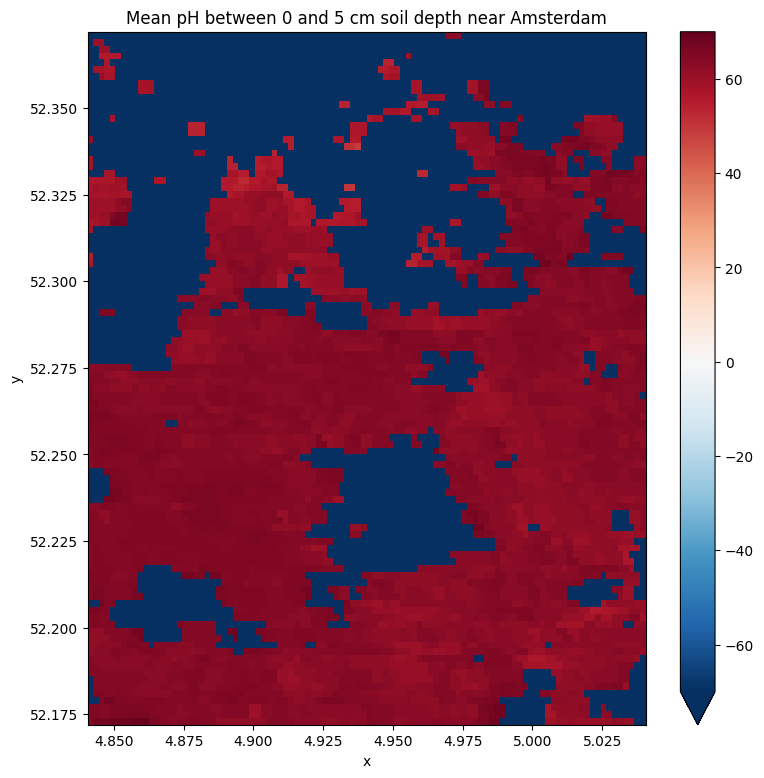

In [43]:
# lets find the point closest to amsterdamn
from scipy.spatial.distance import cdist
amsterdamn_coord = (4.9041, 52.3676)

d_matrix = cdist([amsterdamn_coord], jrc_XY)
center_pt = jrc_XY[d_matrix.argmin()] # lon, lat
print(center_pt)
west = center_pt[0]-0.1
south = center_pt[1]-0.1
east = center_pt[0]+0.1
north = center_pt[1]+0.1

print(west)
print(f'{east} {type(east)}')
print(south)
print(north)

# lets get the data around this point (we'll make it a bigger region to demonstrate)
import matplotlib.pyplot as plt
from soilgrids import SoilGrids

# get data from SoilGrids
soil_grids = SoilGrids()
a_data = soil_grids.get_coverage_data(service_id='phh2o', coverage_id='phh2o_0-5cm_mean', 
                                       west=float(west), south=float(south), east=float(east), north=float(north),  
                                       crs='urn:ogc:def:crs:EPSG::4326',output='test.tif', 
                                       height=100, width=100
                                       )

# show metadata
for key, value in soil_grids.metadata.items():
    print('{}: {}'.format(key,value))


# plot data
a_data.plot(figsize=(9,9))
plt.title('Mean pH between 0 and 5 cm soil depth near Amsterdam')


In [36]:
fill_mask = a_data != -32768
data_arr = a_data.values
data_real = data_arr[fill_mask]
data_real.mean()
# skipping the fill values we can calculate the mean value!

np.float64(63.093459468275974)

Ok we can get our grid for a jrc data point now, lets now make a function that takes these points and gets the full dataset

In [ ]:
from soilgrids import SoilGrids

def get_soilgrid(coord, service_id, coverage_id,
                 crs='urn:ogc:def:crs:EPSG::4326',
                 output='test.tif',
                 resolution=(100, 100),
                 square_len=0.31
                 ):
    # assuming the coord is the center of the grid point, we need to calc the max and min values from the center
    # coord = (lon, lat)
    displace = square_len/2
    
    n, s = coord[1] + displace, coord[1] - displace #  latitude calcs
    e, w = coord[0] + displace, coord[0] - displace #  latitude calcs

    soil_grids = SoilGrids()
    data = soil_grids.get_coverage_data(service_id=service_id, coverage_id=coverage_id, 
                                        west=float(w), south=float(s), east=float(e), north=float(n),  
                                        crs=crs,output=output, 
                                        height=resolution[0], width=resolution[1]
                                        )
    
    return data.values

test = get_soilgrid((4.940522, 52.271991), service_id='phh2o', coverage_id='phh2o_0-5cm_mean')